In [1]:
import numpy as np
from matplotlib import pyplot as plt

def dbmoon(N = 100, d= -5, r=10, w=2):
    w2 = w / 2
    data = np.empty(0)
    while data.shape[0] < N:
        #形成矩阵
        tmp_x = 2 * (r + w2) * (np.random.random([N, 1]) - 0.5)
        tmp_y = (r + w2) * np.random.random([N, 1])
        tmp = np.concatenate((tmp_x, tmp_y), axis=1)
        tmp_ds = np.sqrt(tmp_x * tmp_x + tmp_y * tmp_y)
        #形成双月数据（上层）
        idx = np.logical_and(tmp_ds > (r - w2), tmp_ds < (r + w2))
        idx = (idx.nonzero())[0]

        if data.shape[0] == 0:
            data = tmp.take(idx, axis=0)
        else:
            data = np.concatenate((data, tmp.take(idx, axis=0)), axis=0)
    
    db_moon = data[0: N, :]
    #形成双月数据（下层）
    data_t = np.empty([N, 2])
    data_t[:, 0] = data[0: N, 0] + r
    data_t[:, 1] = -data[0: N, 1] - d
    #数据拼接
    db_moon = np.concatenate((db_moon, data_t), axis=0)
    return db_moon

In [2]:
num_example = 2500
x =  dbmoon(N=num_example // 2)
y = np.concatenate([np.ones([num_example // 2]), -np.ones([num_example // 2])])

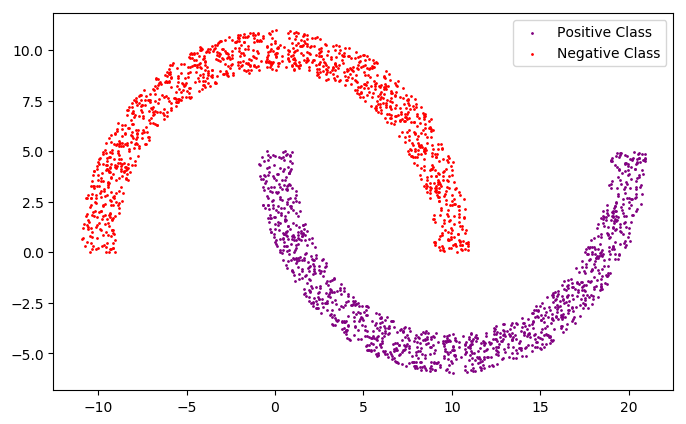

In [3]:
plt.figure(figsize=(8, 5), dpi=100) #设置绘图区域的大小和像素
plt.scatter(x[num_example // 2:, 0], x[num_example // 2:, 1], 1, color='purple', label='Positive Class')
plt.legend(loc='best') #显示图例的位置，自适应方式
plt.scatter(x[: num_example // 2, 0], x[: num_example // 2, 1], 1, color='red', label='Negative Class')
plt.legend(loc='best')
plt.show()

In [4]:
from sklearn.model_selection import train_test_split
# 将数据集打乱并分为训练集与测试集
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=500)

w = np.zeros([2], dtype=np.float32)
b = 0.

def rosenblatt(x):
    z = np.sum(w * x) + b
    if z >= 0:
        return 1
    else:
        return -1


In [5]:
#MSE : 均方误差代价函数
def mse(label, pred):
    return np.average((np.array(label) - np.array(pred)) ** 2)

# 训练模型 2000 次
train_steps = 2000
# 摘要频率
summary_step = 50
# 摘要，记录训练中的代价变化
summary = np.empty([train_steps // summary_step, 2])
# 学习率
lr = 0.1

for i in range(0, train_steps):
    # 评估模型
    if i % summary_step == 0:
        test_out = []
        for j in range(test_y.shape[0]):
            test_out.append(rosenblatt(test_x[j]))
        loss = mse(test_y, test_out)
        idx = int(i / summary_step)
        summary[idx] = np.array([i, loss])
    
    # 取一个训练集中的样本
    one_x, one_y = train_x[i % train_y.shape[0]], train_y[i % train_y.shape[0]]
    # 得到模型输出结果
    out = rosenblatt(one_x)
    # 更新权值
    w = w + lr * (one_y - out) * one_x
    b = b + lr * (one_y - out)


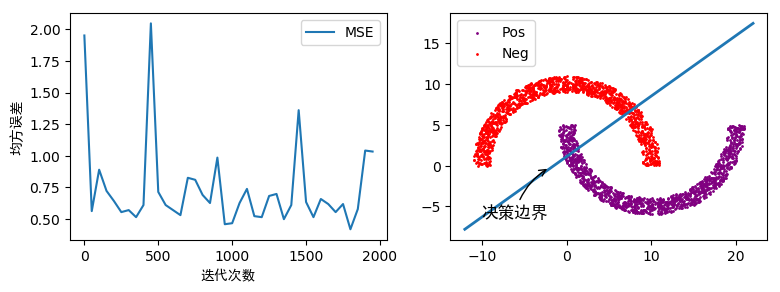

In [6]:
#训练完成之后，我们将训练结果进行可视化
    
plt.figure(figsize=(9, 3), dpi=100)

plt.subplot(1, 2, 1)
plt.plot(summary[:, 0], summary[:, 1], label='MSE')
plt.legend(loc='best')
plt.xlabel('迭代次数', fontproperties='SimHei')
plt.ylabel('均方误差', fontproperties='SimHei')

plt.subplot(1, 2, 2)
plt.scatter(x[num_example // 2:, 0], x[num_example // 2:, 1], 1, color='purple', label='Pos')
plt.legend(loc='best')
plt.scatter(x[: num_example // 2, 0], x[: num_example // 2, 1], 1, color='red', label='Neg')
plt.legend(loc='best')
left_coord_y = (-b - (-12) * w[0]) / w[1]
right_coord_y = (-b - (22) * w[0]) / w[1]
plt.plot([-12, 22], [left_coord_y, right_coord_y], linewidth=2)

plt.annotate(
    '决策边界', xy=(-2, -0.2), xytext=(-10., -6.5), 
     arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=-.2"), 
     fontproperties='SimHei', fontsize=12)

plt.show()

In [7]:
print("2:不意味完全失效；如果MSE持续下降 证明一直在收敛，但收敛速度会受到影响；")
'''
#3
#学习率--步长  评判指标：学习率衰减因子：decay
#decay越小，学习率衰减地越慢，当decay = 0时，学习率保持不变。
#decay越大，学习率衰减地越快，当decay = 1时，学习率衰减最快。

#代码
import numpy as np
import matplotlib.pyplot as plt


# 目标函数:y=x^2
def func(x):
    return np.square(x)


# 目标函数一阶导数:dy/dx=2*x
def dfunc(x):
    return 2 * x
    
def GD_decay(x_start, df, epochs, lr, decay):
    """
    带有学习率衰减因子的梯度下降法。
    :param x_start: x的起始点
    :param df: 目标函数的一阶导函数
    :param epochs: 迭代周期
    :param lr: 学习率
    :param decay: 学习率衰减因子
    :return: x在每次迭代后的位置（包括起始点），长度为epochs+1
    """
    xs = np.zeros(epochs+1)
    x = x_start
    xs[0] = x
    v = 0
    for i in range(epochs):
        dx = df(x)
        # 学习率衰减
        lr_i = lr * 1.0 / (1.0 + decay * i)
        # v表示x要改变的幅度
        v = - dx * lr_i
        x += v
        xs[i+1] = x
    return xs
'''

2:不意味完全失效；如果MSE持续下降 证明一直在收敛，但收敛速度会受到影响；


'\n#3\n#学习率--步长  评判指标：学习率衰减因子：decay\n#decay越小，学习率衰减地越慢，当decay = 0时，学习率保持不变。\n#decay越大，学习率衰减地越快，当decay = 1时，学习率衰减最快。\n\n#代码\nimport numpy as np\nimport matplotlib.pyplot as plt\n\n\n# 目标函数:y=x^2\ndef func(x):\n    return np.square(x)\n\n\n# 目标函数一阶导数:dy/dx=2*x\ndef dfunc(x):\n    return 2 * x\n    \ndef GD_decay(x_start, df, epochs, lr, decay):\n    """\n    带有学习率衰减因子的梯度下降法。\n    :param x_start: x的起始点\n    :param df: 目标函数的一阶导函数\n    :param epochs: 迭代周期\n    :param lr: 学习率\n    :param decay: 学习率衰减因子\n    :return: x在每次迭代后的位置（包括起始点），长度为epochs+1\n    """\n    xs = np.zeros(epochs+1)\n    x = x_start\n    xs[0] = x\n    v = 0\n    for i in range(epochs):\n        dx = df(x)\n        # 学习率衰减\n        lr_i = lr * 1.0 / (1.0 + decay * i)\n        # v表示x要改变的幅度\n        v = - dx * lr_i\n        x += v\n        xs[i+1] = x\n    return xs\n'